## Load DINOv2

In [1]:
from pathlib import Path
import numpy as np
import cv2
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModel
import umap
import matplotlib.pyplot as plt
import pandas as pd

/opt/anaconda3/envs/fish_embed/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
print("1) Starting minimal test")

# Try imports one-by-one
try:
    import torch
    print("2) torch imported")
except Exception as e:
    print("torch import failed:", repr(e))

try:
    from transformers import AutoImageProcessor, AutoModel
    print("3) transformers imported")
except Exception as e:
    print("transformers import failed:", repr(e))

try:
    import cv2
    print("4) cv2 imported")
except Exception as e:
    print("cv2 import failed:", repr(e))

try:
    import ffmpeg
    print("5) ffmpeg imported")
except Exception as e:
    print("ffmpeg import failed:", repr(e))

print("6) All imports done, about to load model...")

VIDEO_ROOT = Path("/Users/wendycao/fish/processed/video_clips_5s")

MODEL_NAME = "facebook/dinov2-base" 

try:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)
    image_processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
    dinov2_model = AutoModel.from_pretrained(MODEL_NAME).to(device)
    dinov2_model.eval()
    print("7) DINOv2 loaded successfully")
except Exception as e:
    print("DINOv2 load failed:", repr(e))

print("8) minimal_test.py finished")



1) Starting minimal test
2) torch imported
3) transformers imported
4) cv2 imported
5) ffmpeg imported
6) All imports done, about to load model...
Using device: cpu
7) DINOv2 loaded successfully
8) minimal_test.py finished


## Helper Functions

In [3]:
def get_middle_frame_bgr(video_path):
    """Return the middle frame (BGR) of a video, or None if failed."""
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        return None

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count <= 0:
        cap.release()
        return None

    mid_idx = frame_count // 2
    cap.set(cv2.CAP_PROP_POS_FRAMES, mid_idx)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        return None
    return frame  # BGR image


In [4]:
@torch.no_grad()
def dinov2_embed_frame_rgb(frame_rgb):
    """Return a 1D DINOv2 embedding from an RGB image frame."""
    img = Image.fromarray(frame_rgb)
    inputs = image_processor(images=img, return_tensors="pt").to(device)
    outputs = dinov2_model(**inputs)
    cls_emb = outputs.last_hidden_state[:, 0, :]  # CLS token
    return cls_emb.squeeze(0).cpu().numpy()


In [5]:
def dinov2_embed_clip(video_path):
    """Return DINOv2 embedding for the middle frame of a video clip."""
    frame_bgr = get_middle_frame_bgr(video_path)
    if frame_bgr is None:
        return None

    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    return dinov2_embed_frame_rgb(frame_rgb)


## Embeddings

In [9]:
embeddings = []
species_labels = []
clip_paths = []

if not VIDEO_ROOT.exists():
    raise SystemExit(f"VIDEO_ROOT does not exist: {VIDEO_ROOT}")

species_dirs = [d for d in VIDEO_ROOT.iterdir() if d.is_dir()]
print(f"Found {len(species_dirs)} species folders under {VIDEO_ROOT}")

for species_dir in sorted(species_dirs):
    species = species_dir.name
    
    # 🔥 Only load cropped 5s clips
    mp4_files = sorted(species_dir.glob("*_cropped.mp4"))

    print(f"\nSpecies: {species}  ({len(mp4_files)} cropped clips)")
    for i, clip_path in enumerate(mp4_files):
        rel = clip_path.relative_to(VIDEO_ROOT)
        print(f"  [{i+1}/{len(mp4_files)}] {rel}")

        emb = dinov2_embed_clip(clip_path)
        if emb is None:
            print("    -> failed to embed (skipping)")
            continue

        embeddings.append(emb)
        species_labels.append(species)
        clip_paths.append(str(rel))

embeddings = np.stack(embeddings)
print("\nCollected embeddings:", embeddings.shape)


Found 46 species folders under /Users/wendycao/fish/processed/video_clips_5s

Species: Abudefduf saxatilis  (8 cropped clips)
  [1/8] Abudefduf saxatilis/FEC-00136 Abudefduf saxatilis_det000_cropped.mp4
  [2/8] Abudefduf saxatilis/FEC-00137 Abudefduf saxatilis_det000_cropped.mp4
  [3/8] Abudefduf saxatilis/FEC-00138 Abudefduf saxatilis_det000_cropped.mp4
  [4/8] Abudefduf saxatilis/FEC-00138 Abudefduf saxatilis_det001_cropped.mp4
  [5/8] Abudefduf saxatilis/FEC-00138 Abudefduf saxatilis_det002_cropped.mp4
  [6/8] Abudefduf saxatilis/FEC-00138 Abudefduf saxatilis_det003_cropped.mp4
  [7/8] Abudefduf saxatilis/FEC-00139 Abudefduf saxatilis_det000_cropped.mp4
  [8/8] Abudefduf saxatilis/FEC-00140 Abudefduf saxatilis_det000_cropped.mp4

Species: Acanthurus coeruleus  (5 cropped clips)
  [1/5] Acanthurus coeruleus/FEC-00006 Acanthurus coeruleus_det000_cropped.mp4
  [2/5] Acanthurus coeruleus/FEC-00007 Acanthurus coeruleus_det000_cropped.mp4
  [3/5] Acanthurus coeruleus/FEC-00008 Acanthurus 

## UMAP

In [10]:
print("Running UMAP...")
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42,
)
emb_2d = reducer.fit_transform(embeddings)
print("UMAP done. emb_2d shape:", emb_2d.shape)

Running UMAP...


/opt/anaconda3/envs/fish_embed/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP done. emb_2d shape: (265, 2)


## Plot

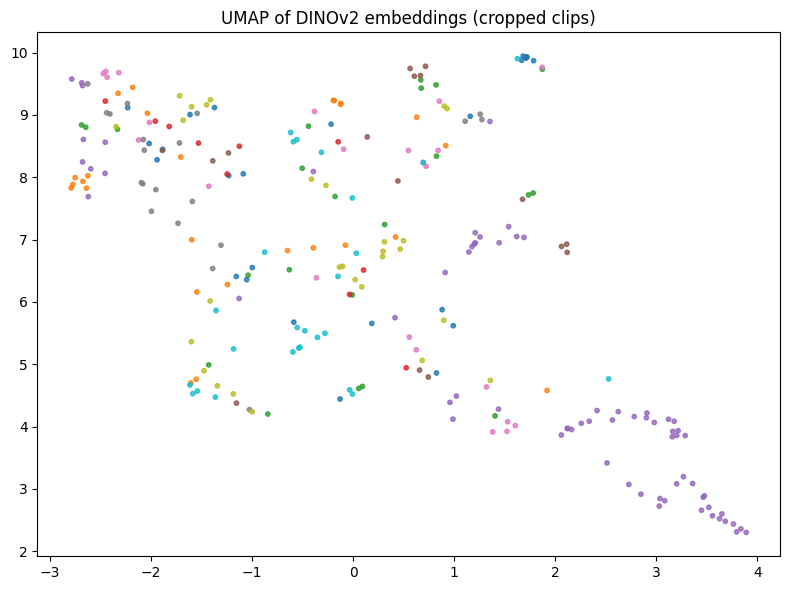

In [11]:
if emb_2d.shape[0] == 0:
    print("No points to plot (emb_2d is empty).")
else:
    # turn species names into color indices
    unique_species = sorted(set(species_labels))
    species_to_idx = {s: i for i, s in enumerate(unique_species)}
    color_indices = np.array([species_to_idx[s] for s in species_labels])

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        emb_2d[:, 0],
        emb_2d[:, 1],
        c=color_indices,
        s=10,
        alpha=0.8,
        cmap="tab10",
    )
    plt.title("UMAP of DINOv2 embeddings (cropped clips)")
    plt.tight_layout()

    # show on screen
    plt.show()

## Save embeddings

In [12]:
out_dir = VIDEO_ROOT.parent / "dinov2_embeddings"
out_dir.mkdir(exist_ok=True)
np.save(out_dir / "embeddings.npy", embeddings)

meta_df = pd.DataFrame({
    "clip_path": clip_paths,
    "species": species_labels,
})
meta_df.to_csv(out_dir / "metadata.csv", index=False)

print(f"\nSaved embeddings to: {out_dir / 'embeddings.npy'}")
print(f"Saved metadata to:   {out_dir / 'metadata.csv'}")



Saved embeddings to: /Users/wendycao/fish/processed/dinov2_embeddings/embeddings.npy
Saved metadata to:   /Users/wendycao/fish/processed/dinov2_embeddings/metadata.csv
